# Text Analysis - LDA Topic Model

Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data, which finds some natural groups of items (topics) even when we’re not sure what we’re looking for.

Latent Dirichlet Allocation (LDA) is one of the most popular topic modeling methods. It is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar.

## Data Description
The data used for this analysis is a historical dataset containing 13,087 press releases from the Department of Justice's (DOJ) website https://www.justice.gov/news. The DOJ typically publishes several releases per day and this dataset spans from 2009 to July 2018. The releases contain information such as outcomes of criminal cases, notable actions taken against felons, or other updates about the current administration. This dataset only includes releases categorized as "Press release" and does not contain those which have been labeled as "Speeches". Some releases are tagged with topics or related agencies.

The dataset can be found here: https://www.kaggle.com/datasets/jbencina/department-of-justice-20092018-press-releases

We are asking ourselves a simple question: what are the documents talking about?


## LDA 
In order to answer this question, I will use a topic modelling process called Latent Dirichlet Allocation (LDA) to try and find out what the documents are talking about. Each document is made up of various words, and each topic also has various words belonging to it. The aim of LDA is to find topics a document belongs to, based on the words in it.


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import json
import nltk
import glob
import datetime

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\krist\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\krist\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


After importing the required libaries, we can then read the data in. The data is in a JSON format and be read in as follows:

In [ ]:
# load json data
docs = pd.read_json('combined.json', lines=True)
docs.head()
#docs['contents']

,id,title,contents,date,topics,components
0,None,Convicted Bomb Plotter Sentenced to 30 Years,"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01T00:00:00-04:00,[],[National Security Division (NSD)]
1,12-919,$1 Million in Restitution Payments Announced t...,WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25T00:00:00-04:00,[],[Environment and Natural Resources Division]
2,11-1002,$1 Million Settlement Reached for Natural Reso...,BOSTON– A $1-million settlement has been...,2011-08-03T00:00:00-04:00,[],[Environment and Natural Resources Division]
3,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08T00:00:00-05:00,[],[Environment and Natural Resources Division]
4,18-898,$100 Million Settlement Will Speed Cleanup Wor...,"The U.S. Department of Justice, the U.S. Envir...",2018-07-09T00:00:00-04:00,[Environment],[Environment and Natural Resources Division]


Here we can see the first few documents in the file. Next, let us define the stopwords we will be using in the data preparation.

In [ ]:
stopwords = stopwords.words("english")
print (stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The following fuction lemmatizes our words. Lemmatization is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma (the word's base or dictionary form). 

Take for example the words cars, car's, and cars'. After lemmatization these will be returned as "car". Note that this is a bit different from stemming, where stemming typically takes a more crude approach of chopping off the ends of words.

In [ ]:
def lemmatization(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    nlp = spacy.load("en_core_web_sm",disable=["parser", "ner"])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                new_text.append(token.lemma_)
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)


lemmatized_texts = lemmatization(docs['contents'])
print (lemmatized_texts[0][0:90])

convict attempt use weapon mass destruction explosive connection plot detonate vehicle bom


Next, let us put all of our words into a list:

In [ ]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(lemmatized_texts)

print (data_words[0][0:20])


['convict', 'attempt', 'use', 'weapon', 'mass', 'destruction', 'explosive', 'connection', 'plot', 'detonate', 'vehicle', 'bomb', 'annual', 'tree', 'lighting', 'ceremony', 'sentence', 'today', 'serve', 'year']


Now, we can try and add bigrams and trigrams into our corpus. This is important as N-grams help us see which words often show up together. 

In [ ]:
# bigrams and trigrams
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return([bigram[doc] for doc in texts])

def make_trigrams(texts):
    return ([trigram[bigram[doc]] for doc in texts])

data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_bigrams)

print (data_bigrams_trigrams[0][0:20])

['convict', 'attempt', 'use', 'weapon_mass_destruction', 'explosive', 'connection', 'plot', 'detonate', 'vehicle', 'bomb', 'annual_tree_lighting', 'ceremony', 'sentence', 'today', 'serve', 'year', 'prison', 'follow', 'lifetime', 'term']


The final step before fitting our LDA model is to remove "low-value" words from our corpus using TF-IDF. This filters out words that appear frequently in multiple documents, and thus do not add any value to our model.

In [ ]:
#TF-IDF REMOVAL
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)

texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print (corpus[0][0:20])

tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.03 # can change
words  = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

Finally, let us fit our LDA model using our cleaned corpus:

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

We can note that there are some parameters here that we can change. For this assignment, I tried several different low value thresholds in the TF-IDF removal, as well as different numbers of topics. Ultimately, I decided on using 0.03 as my threshold, and 5 topics. I found this to be a good number of topics that resulted in coherent topics.

Next, we can visualize the results using pyLDAvis: 

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=30)
vis

C:\Users\krist\AppData\Roaming\Python\Python38\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.134941  0.209357       1        1  29.023729
1     -0.017110 -0.279765       2        1  21.774029
4     -0.292528 -0.099317       3        1  19.554343
2     -0.103213  0.252779       4        1  16.824459
0      0.277911 -0.083054       5        1  12.823440, topic_info=            Term          Freq         Total Category  logprob  loglift
1388         tax  13384.000000  13384.000000  Default  30.0000  30.0000
518   settlement   8388.000000   8388.000000  Default  29.0000  29.0000
588   indictment  13416.000000  13416.000000  Default  28.0000  28.0000
656       charge  15262.000000  15262.000000  Default  27.0000  27.0000
946        fraud  12158.000000  12158.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
257          use   1412.663528   6501.110977   Topic5  -5.2575   0.5274
1183       steal   1036.002588   2095.421642   Topic5  -5.5676   1.3495
590   individual   1232.553546   5062.029949   Topic5  -5.3939   0.6412
16        arrest   1124.858711   3235.982187   Topic5  -5.4853   0.9972
794   government   1205.815850  10410.564806   Topic5  -5.4158  -0.1018

[345 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1465      3  0.128336   abuse
1465      4  0.286581   abuse
1465      5  0.584582   abuse
641       3  0.042811  access
641       5  0.957043  access
...     ...       ...     ...
269       2  0.609549    work
269       3  0.072514    work
269       5  0.187388    work
271       1  0.510230    year
271       4  0.489664    year

[564 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1])

Here we can see that I have chosen 5 topics for the LDA model. Looking at the words associated with each topic, we can get a better sense of what each topic is about.

Topic 1:
- This topic has words such as "tax, "fraud", "false", "conspiracy"
- Looking at the words associated with this topic, we can guess that this topic is about tax fraud.

Topic 2:
- This topic has words such as "criminal", "law", "enforcement", "public", "state"
- Looking at the words associated with this topic, we can guess that this topic is about law enforcement.

Topic 3:
- This topic has words such as "settlement", "government", "health", "program", "care"
- Looking at the words associated with this topic, we can guess that this topic is about medical settlements.

Topic 4:
- This topic has words such as "charge", "sentence", "murder", "assault", "attack"
- Looking at the words associated with this topic, we can guess that this topic is about violent crime.

Topic 5: 
- This topic has words such as "child", "victim", "military", "computer", "travel"
- Looking at the words associated with this topic, we can guess that this topic is about child abuse or perhaps something military related.


## Relative weight of each topic over time.

Next, we are interested in analyzing the time specific probability that each topic will be discussed. As a toy example, suppose there are 2 topics and 2 time periods. In the first time period, only topic 1 is discussed. Therefore, in t=1, the weight assigned to topic 1 is 1.00 and the weight assigned to topic 2 is 0.00. In t=2, both topics are discussed equally and are thus given equal weight (0.5 each). Ultimately, we want a plot which displays the relative weight of each topic per year. In this context, I have fit my LDA model with 5 topics, and each time period will be a year. The relative weights can be estimated using the output from the LDA model, and I will do so below.

First, we can note that we are able to extract the different topic and word weights from our LDA model. For example, here we can see the weights for each word in each topic.

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.011*"child" + 0.011*"victim" + 0.010*"foreign" + 0.009*"complaint" + 0.008*"defendant" + 0.008*"information" + 0.008*"military" + 0.007*"sell" + 0.006*"computer" + 0.006*"access"


Topic: 1 
Words: 0.012*"criminal" + 0.012*"law" + 0.009*"enforcement" + 0.009*"investigation" + 0.008*"crime" + 0.008*"state" + 0.007*"department" + 0.007*"financial" + 0.007*"public" + 0.006*"agreement"


Topic: 2 
Words: 0.015*"charge" + 0.015*"sentence" + 0.015*"member" + 0.013*"indictment" + 0.013*"defendant" + 0.012*"prison" + 0.010*"year" + 0.010*"conspiracy" + 0.009*"guilty" + 0.009*"victim"


Topic: 3 
Words: 0.022*"tax" + 0.018*"fraud" + 0.015*"charge" + 0.014*"indictment" + 0.013*"return" + 0.013*"scheme" + 0.012*"count" + 0.012*"false" + 0.012*"account" + 0.011*"conspiracy"


Topic: 4 
Words: 0.020*"settlement" + 0.015*"health" + 0.013*"company" + 0.013*"government" + 0.012*"program" + 0.012*"care" + 0.008*"claim" + 0.008*"complaint" + 0.008*"facility" + 0.008*"patient"




Next, we can see how each document is made up of the different topics. Using the get_documents_topics() function we can see the weights of each topics for each document. 

For example, we see here that document one is primarily made up of Topic 3 (recall that Python starts index at 0), with a weight of 0.619.

In [ ]:
print(lda_model.get_document_topics(corpus[0],minimum_probability=0.0))

[(0, 0.19125552), (1, 0.18792363), (2, 0.61875343), (3, 0.0012290312), (4, 0.0008384072)]


Now, in order to calculate the relative weight of each topic over time, I will use the results from the LDA model to show our desired results. 

I will combine all the documents for each year, and then use the topic model to calculate the relative weights by year using the words and scores from the LDA model.

In [ ]:
#convert 2d array to dataframe
data_df = pd.DataFrame(data_bigrams_trigrams)

#add id and date
data_df_id = pd.concat([docs[['id', 'date']].reset_index(drop=True), data_df], axis=1)

#melt words into one column
data_df_id_melt = pd.melt(data_df_id, id_vars=['id', 'date'], value_name = 'word').drop('variable', axis = 1).dropna()

#extract year from date
data_df_id_melt['year'] = [datetime. datetime. strptime(x[0:-6], "%Y-%m-%dT%H:%M:%S").year for x in data_df_id_melt['date']]


In [ ]:
#extract words and scores from LDA model
word_topics = pd.DataFrame(gensim.models.ldamodel.LdaModel.get_topics(lda_model), columns = [id2word.get(x) for x in range(len(id2word))]).reset_index(level=0)

#convert to long df
word_topics_melt = pd.melt(word_topics, id_vars=['level_0'], var_name = 'word', value_name = 'prop')

<ipython-input-238-2073915148b3>:5: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  word_topics_melt = pd.melt(word_topics, id_vars=['level_0'], var_name = 'word', value_name = 'prop')


In [ ]:
#join weights and topics to dates by words
topic_terms_weights = pd.merge(data_df_id_melt, word_topics_melt, on='word', how='left')

#summarise each topic as proportion by year
yearly_topic_terms = topic_terms_weights.groupby(['year', 'level_0']).agg({"prop": "sum"})
yearly_topic_terms_prop = yearly_topic_terms / yearly_topic_terms.groupby('year').sum()

Finally, we can plot the relative weights of each of the topics over time like so:

Text(0.5, 1.0, 'Relative Weights of Topics Over Time')

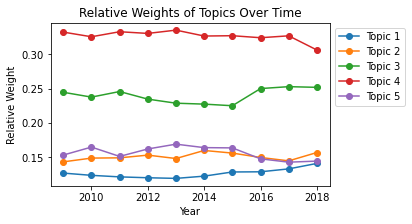

In [ ]:
#pivot the dataframe
yearly_topic_prop_plot = yearly_topic_terms_prop.reset_index(level=0).reset_index(level=0).pivot(index='year', columns='level_0', values='prop')

#finally plot the relative weights of the topics over time
plt = yearly_topic_prop_plot.plot(figsize = (5, 3),marker='o')
plt.legend(loc='upper left', labels=["Topic 1","Topic 2","Topic 3", "Topic 4", "Topic 5"],bbox_to_anchor=(1, 1))
plt.set_xlabel("Year")
plt.set_ylabel("Relative Weight")
plt.set_title("Relative Weights of Topics Over Time")


Here we can see the relative weights of the topics over time. Looking at the plot, we see that the topic that had the highest relative weight in all years was Topic 4, and the topic with the lowest relative weight over time was Topic 1. We note that Topics 2 and 5 had relaively low weights over time as well. We can see that there was an increase in Topic 3's relative weight and a decrease in Topic 5's between 2015-2016.